## 02. Tratamiento de Datos

In [1]:
# Libraries

import numpy as np
import pandas as pd

# Plots

import matplotlib
from matplotlib import pyplot as plt 
import seaborn as sns 

# Metricas

from scipy import stats as sts # normality test JB
from sklearn import model_selection
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split # split data
from sklearn.metrics import mean_squared_error # MSE
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing # estandarization
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest # outliers
from math import sqrt # sqrt
import math
import itertools # aplanar arrays

import random
random.seed(12345)

Importamos nuestro dataset:

In [2]:
eda_set = '../data/EDA_set.csv'

In [3]:
prestamo = pd.read_csv(eda_set)

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (144,145,146) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
prestamo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 150 entries, id to settlement_term
dtypes: float64(111), int64(1), object(38)
memory usage: 114.4+ MB


Queremos mantener la mayor cantidad de variables al principio, porque cuantas más variables tenga, más posibilidades tendrá de generar un mejor modelo de predicción. Solo eliminaremos las variables con un porcentaje superior al 805%.

In [5]:
NaN = pd.DataFrame(round(prestamo.isnull().sum()/len(prestamo.index)*100,2),columns=['null_percent'])

In [6]:
Filtro = NaN['null_percent']>80
Nulls = NaN[Filtro]
prestamo2 = prestamo.drop(list(Nulls.index), axis=1)

Comprobamos la dimensión de nuestro dataset:

In [7]:
prestamo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 111 entries, id to debt_settlement_flag
dtypes: float64(84), int64(1), object(26)
memory usage: 84.7+ MB


Debido a que cuando se solicita un préstamo no se dispone una determinada información, procedemos a excluir de nuestro analisis las siguientes variables:

In [8]:
del prestamo2['sub_grade']
del prestamo2['emp_title']
del prestamo2['issue_d']
del prestamo2['addr_state']
del prestamo2['funded_amnt']
del prestamo2['funded_amnt_inv']
del prestamo2['title']
del prestamo2['last_credit_pull_d']
del prestamo2['last_pymnt_d']
del prestamo2['debt_settlement_flag']
del prestamo2['total_pymnt']
del prestamo2['total_pymnt_inv']
del prestamo2['total_rec_int']
del prestamo2['total_rec_late_fee']
del prestamo2['total_rec_prncp']
del prestamo2['last_pymnt_amnt']
del prestamo2['out_prncp']
del prestamo2['out_prncp_inv']
del prestamo2['hardship_flag']
del prestamo2['pymnt_plan']
del prestamo2['int_rate']
del prestamo2['url']
del prestamo2['next_pymnt_d']
del prestamo2['revol_util']

Debido a que es ilegal pedir el Codigo Postal, eliminamos la variables:
    

In [9]:
del prestamo2['zip_code']

No nos importa si el préstamo se otorgó total o parcialmente así que procemos a eliminar 'initial_list_status'.

In [10]:
del prestamo2['initial_list_status']

Por el mismo motivo eliminamos 'disbursement_method'.

In [11]:
del prestamo2['disbursement_method']

Calculamos el procentaje de NAs:

In [12]:
porcentaje_NaN = prestamo2.apply(lambda x: sum(x.isna()/len(prestamo2)))
porcentaje_NaN.sort_values(ascending = False).head(20)

mths_since_recent_bc_dlq          0.75939
mths_since_last_major_derog       0.72399
mths_since_recent_revol_delinq    0.64884
mths_since_last_delinq            0.48469
il_util                           0.12674
mths_since_recent_inq             0.11366
emp_length                        0.06302
num_tl_120dpd_2m                  0.04925
mo_sin_old_il_acct                0.02521
mths_since_rcnt_il                0.02521
bc_util                           0.01128
percent_bc_gt_75                  0.01087
bc_open_to_buy                    0.01084
mths_since_recent_bc              0.01027
dti                               0.00069
all_util                          0.00012
avg_cur_bal                       0.00002
total_acc                         0.00000
collections_12_mths_ex_med        0.00000
last_fico_range_low               0.00000
dtype: float64

A continuación vamos a dividir nuestro dataset entre variables categóricas y númericas:

In [13]:
numericas = prestamo2.select_dtypes(include = [np.number])
categoricas = prestamo2.select_dtypes(include = [np.object])

In [14]:
numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 75 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              100000 non-null  int64  
 1   loan_amnt                       100000 non-null  float64
 2   installment                     100000 non-null  float64
 3   annual_inc                      100000 non-null  float64
 4   dti                             99931 non-null   float64
 5   delinq_2yrs                     100000 non-null  float64
 6   fico_range_low                  100000 non-null  float64
 7   fico_range_high                 100000 non-null  float64
 8   inq_last_6mths                  100000 non-null  float64
 9   mths_since_last_delinq          51531 non-null   float64
 10  open_acc                        100000 non-null  float64
 11  pub_rec                         100000 non-null  float64
 12  revol_bal        

In [15]:
categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   term                 100000 non-null  object
 1   grade                100000 non-null  object
 2   emp_length           93698 non-null   object
 3   home_ownership       100000 non-null  object
 4   verification_status  100000 non-null  object
 5   loan_status          100000 non-null  object
 6   purpose              100000 non-null  object
 7   earliest_cr_line     100000 non-null  object
 8   application_type     100000 non-null  object
dtypes: object(9)
memory usage: 6.9+ MB


In [16]:
categoricas.nunique()

term                     2
grade                    7
emp_length              11
home_ownership           5
verification_status      3
loan_status              7
purpose                 13
earliest_cr_line       627
application_type         2
dtype: int64

A las variables númericas vamos a imputarles la media a los NAs.

In [17]:
numericas = numericas.apply(lambda x: x.replace("", np.nan))
numericas = numericas.apply(lambda x: x.fillna(x.mean()))

In [18]:
numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 75 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              100000 non-null  int64  
 1   loan_amnt                       100000 non-null  float64
 2   installment                     100000 non-null  float64
 3   annual_inc                      100000 non-null  float64
 4   dti                             100000 non-null  float64
 5   delinq_2yrs                     100000 non-null  float64
 6   fico_range_low                  100000 non-null  float64
 7   fico_range_high                 100000 non-null  float64
 8   inq_last_6mths                  100000 non-null  float64
 9   mths_since_last_delinq          100000 non-null  float64
 10  open_acc                        100000 non-null  float64
 11  pub_rec                         100000 non-null  float64
 12  revol_bal        

A las variables categóricas vamos a imputarles la moda a los NAs.

In [19]:
categoricas = categoricas.apply(lambda x: x.replace("", np.nan))
categoricas = categoricas.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [20]:
categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   term                 100000 non-null  object
 1   grade                100000 non-null  object
 2   emp_length           100000 non-null  object
 3   home_ownership       100000 non-null  object
 4   verification_status  100000 non-null  object
 5   loan_status          100000 non-null  object
 6   purpose              100000 non-null  object
 7   earliest_cr_line     100000 non-null  object
 8   application_type     100000 non-null  object
dtypes: object(9)
memory usage: 6.9+ MB


In [21]:
prestamo3 = pd.concat([numericas, categoricas], axis = 1)

In [22]:
prestamo3.head(10)

,id,loan_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,...,total_il_high_credit_limit,term,grade,emp_length,home_ownership,verification_status,loan_status,purpose,earliest_cr_line,application_type
0,112435993,2300.0,77.08,10000.00,21.61,0.0,700.0,704.0,1.0,33.291688,...,0.0,36 months,C,10+ years,OWN,Not Verified,Current,credit_card,Sep-1985,Individual
1,112290210,16000.0,360.95,94000.00,25.61,0.0,715.0,719.0,0.0,33.291688,...,16000.0,60 months,C,10+ years,MORTGAGE,Not Verified,Current,debt_consolidation,Jun-1992,Individual
2,112436985,6025.0,209.01,46350.00,8.88,0.0,700.0,704.0,0.0,33.291688,...,0.0,36 months,C,7 years,MORTGAGE,Not Verified,Current,home_improvement,Jun-2002,Individual
3,112439006,20400.0,652.91,44000.00,27.06,0.0,760.0,764.0,1.0,33.291688,...,56458.0,36 months,B,10+ years,RENT,Source Verified,Current,car,Jan-2007,Individual
4,112438929,13000.0,431.73,85000.00,6.79,1.0,660.0,664.0,0.0,16.000000,...,11802.0,36 months,B,10+ years,MORTGAGE,Source Verified,Current,debt_consolidation,Feb-2002,Individual
5,112230200,12000.0,384.06,70000.00,18.34,0.0,670.0,674.0,0.0,35.000000,...,30780.0,36 months,B,10+ years,MORTGAGE,Not Verified,Current,debt_consolidation,Aug-1997,Individual
6,112210041,6000.0,194.79,37107.19,30.63,0.0,680.0,684.0,0.0,70.000000,...,39869.0,36 months,B,7 years,MORTGAGE,Source Verified,Current,medical,Mar-1992,Individual
7,112360031,12000.0,285.80,69800.00,31.43,0.0,690.0,694.0,1.0,33.291688,...,66669.0,60 months,C,6 years,RENT,Not Verified,Current,debt_consolidation,Feb-2006,Individual
8,112038251,11575.0,359.26,153000.00,16.99,0.0,720.0,724.0,0.0,24.000000,...,120572.0,36 months,A,6 years,OWN,Not Verified,Fully Paid,credit_card,Jul-1994,Individual
9,112134207,20400.0,413.35,110000.00,11.07,0.0,780.0,784.0,1.0,40.000000,...,56264.0,60 months,A,10+ years,MORTGAGE,Not Verified,Current,major_purchase,May-1987,Individual


A continuación vamos a dividir la siguiente variable para poder trabajar con ella:

In [23]:
x = prestamo3['earliest_cr_line'] # la duplicamos

In [24]:
x = x.astype(str) # convert to string

In [25]:
len(x) 

100000

In [26]:
x = x.map(lambda x: x.split('-'))

In [27]:
x.iloc[2]

['Jun', '2002']

In [28]:
x.max()

['Sep', '2013']

In [29]:
x = x.map(lambda x: 2019 - int(x[1]))

In [30]:
x

0        34
1        27
2        17
3        12
4        17
         ..
99995    17
99996    18
99997     6
99998    13
99999    22
Name: earliest_cr_line, Length: 100000, dtype: int64

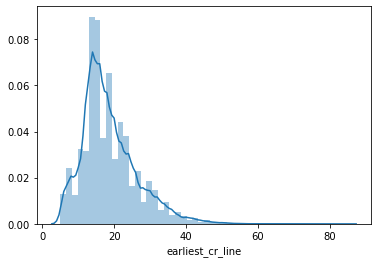

In [31]:
sns.distplot(x);

Una vez la hemos dividido, la eliminamos:

In [32]:
prestamo3['earliest_cr_line'] = x 
del x

Vamos a reducir la dimensión de la variable 'home_ownership' para que no nos devuelva tantas categorías:

In [33]:
prestamo3['home_ownership'].value_counts()

MORTGAGE    49877
RENT        38905
OWN         11214
ANY             2
NONE            2
Name: home_ownership, dtype: int64

In [34]:
prestamo3['home_ownership'] = np.where((prestamo3['home_ownership'] != 'OWN') & (prestamo3['home_ownership'] != 'RENT'),
                                    'OTHER', prestamo3['home_ownership'].values)

In [35]:
prestamo3['home_ownership'].value_counts()

OTHER    49881
RENT     38905
OWN      11214
Name: home_ownership, dtype: int64

Vamos a reducir la dimensión de la variable 'emp_length':
* De menos de 1 año a 5 años.
* De 6 años a 10 años o más.

In [36]:
prestamo3['emp_length'].value_counts()

10+ years    39865
2 years       9460
< 1 year      9036
3 years       8074
1 year        6634
4 years       6142
5 years       6054
6 years       4295
7 years       3654
9 years       3649
8 years       3137
Name: emp_length, dtype: int64

In [37]:
prestamo3['emp_length'] = np.where((prestamo3['emp_length'] == '< 1 year') | 
                                       (prestamo3['emp_length'] == '1 year') |
                                       (prestamo3['emp_length'] == '2 years') | 
                                       (prestamo3['emp_length'] == '3 years') | 
                                       (prestamo3['emp_length'] == '4 years') | 
                                       (prestamo3['emp_length'] == '5 years'), 
                                       '<= 5 years', '6+ years')

In [38]:
prestamo3['emp_length'].value_counts()

6+ years      54600
<= 5 years    45400
Name: emp_length, dtype: int64

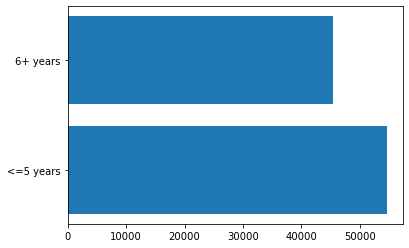

In [39]:
height = prestamo3['emp_length'].value_counts()
bars = ('<=5 years', '6+ years')
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
 
# Show graphic
plt.show()

Para mantener la variable 'grado' y no crear tan dummies como categorías tiene la variable, aplicaremos un encondig ordinal a la variable. El método será el siguiente:

Tenemos 7 categorías desde la mejor calificación, 'A', hasta la peor calificación 'G'.

El orden es A> B> C> D> E> F> G.

La nueva codificación será 6> 5> 4> 3> 2> 1> 0

In [40]:
prestamo3['grade'].value_counts()

C    34938
B    29854
A    17067
D    11321
E     4512
F     1576
G      732
Name: grade, dtype: int64

In [41]:
# first we create a mapper

mapper = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}

# now we map the column and replace the values

prestamo3['grade'] = prestamo3['grade'].replace(mapper)

Debido a todas las transformaciones realizadas, el índice del marco de datos ha cambiado por lo que hay que reiniciarlo:

In [42]:
prestamo4 = prestamo3.reset_index(drop = True)

En este momento tenemos nuestro conjunto de datos limpio, filtrado y reducido dimensionalmente.

### Outliers

El método que usaremos para detectar valores atípicos se llama Bosque de aislamiento. Aísla explícitamente las anomalías que construyen puntos y regiones normales asignando una puntuación a cada punto de datos. Aprovecha el hecho de que las anomalías son los puntos de datos minoritarios y que tienen valores de atributo que son muy diferentes de los de las instancias normales. Este algoritmo funciona muy bien con conjuntos de datos de muy alta dimensión y demostró ser una forma muy eficaz de detectar anomalías.

In [43]:
IF = IsolationForest(max_samples = 100, contamination = 0.05, bootstrap = False, random_state = 1)

In [44]:
%%time

outliers = IF.fit_predict(numericas)
outliers

CPU times: user 11.7 s, sys: 1.99 s, total: 13.7 s
Wall time: 13.8 s


array([1, 1, 1, ..., 1, 1, 1])

This method is very interesting but, why a sample is considered as an outlier by Isolation Forest? We will extract the first outlier was calculated and see if it is really an outlier.

In [45]:
primer_outlier = pd.DataFrame({"Variable":numericas.iloc[1].index, "Valores": numericas.iloc[1]}).set_index("Variable")
primer_outlier

,Valores
Variable,
id,1.122902e+08
loan_amnt,1.600000e+04
installment,3.609500e+02
annual_inc,9.400000e+04
dti,2.561000e+01
...,...
tax_liens,0.000000e+00
tot_hi_cred_lim,3.199000e+05
total_bal_ex_mort,4.483000e+04


The Isolation Forest returns us an array with 1 and -1. -1 indicates an outlier, so we need to know their index positions in order to delete the samples from the numerical dataframe.

In [46]:
# I do a loop in order to get the index of every -1

indices_outliers = []
for i in range(0,len(outliers)):
    if outliers[i] == -1:
        indices_outliers.append(i)

        
len(indices_outliers)

5000

According to the results we have 50 000 outliers. We have a list of the index of every row considered as an outliers, we drop them of the dataset.

In [47]:
# deletting outliers

prestamo3.drop(indices_outliers, axis = 0, inplace = True)

In [48]:
# reseting the index

prestamo4 = prestamo3.reset_index(drop = True)

### Dummies 

Procedemos a tratar nuestra variable endógena "loan_status":

In [49]:
numericas = prestamo4.select_dtypes(include = [np.number])
categoricas = prestamo4.select_dtypes(include = [np.object])

In [50]:
numericas['estado_prestamo'] = np.where((categoricas['loan_status'] == 'Fully Paid'), 0, 1)

<ipython-input-50-cda29901609a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numericas['estado_prestamo'] = np.where((categoricas['loan_status'] == 'Fully Paid'), 0, 1)


In [51]:
numericas['estado_prestamo']

0        1
1        1
2        1
3        1
4        1
        ..
94995    1
94996    1
94997    1
94998    1
94999    1
Name: estado_prestamo, Length: 95000, dtype: int64

In [52]:
del categoricas['loan_status']

A continuación vamos a convertir las variables categóricas a variables dummies:

In [53]:
list(categoricas)

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type']

In [54]:
dummies = pd.get_dummies(categoricas)

In [55]:
dummies.head()

,term_ 36 months,term_ 60 months,emp_length_6+ years,emp_length_<= 5 years,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App
0,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [56]:
dummies['grade'] = prestamo4['grade']

In [57]:
dummies.head()

,term_ 36 months,term_ 60 months,emp_length_6+ years,emp_length_<= 5 years,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App,grade
0,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,4
1,0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,4
2,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,4
3,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,5
4,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,5


### Escalar

In [58]:
escalar = MinMaxScaler()
num_escaladas = escalar.fit_transform(numericas)
numericas = pd.DataFrame(num_escaladas, index = numericas.index, columns = numericas.columns)

In [59]:
numericas.head()

,id,loan_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,grade,earliest_cr_line,estado_prestamo
0,0.999952,0.033333,0.027792,0.001124,0.021632,0.000000,0.216216,0.215054,0.2,0.206781,...,1.0,0.0,0.0,0.002165,0.002984,0.013849,0.000000,0.666667,0.3625,1.0
1,0.998648,0.384615,0.195791,0.010562,0.025636,0.000000,0.297297,0.295699,0.0,0.206781,...,1.0,0.0,0.0,0.097552,0.034199,0.009776,0.011857,0.666667,0.2750,1.0
2,0.999961,0.128846,0.105870,0.005208,0.008889,0.000000,0.216216,0.215054,0.0,0.206781,...,0.0,0.0,0.0,0.041991,0.009479,0.071690,0.000000,0.666667,0.1500,1.0
3,0.999979,0.497436,0.368578,0.004944,0.027087,0.000000,0.540541,0.537634,0.2,0.206781,...,0.0,0.0,0.0,0.031518,0.047553,0.180855,0.041839,0.833333,0.0875,1.0
4,0.999979,0.307692,0.237680,0.009551,0.006797,0.052632,0.000000,0.000000,0.0,0.099379,...,1.0,0.0,0.0,0.005978,0.011696,0.031772,0.008746,0.833333,0.1500,1.0


Concatenamos las dummies a nuestro dataframe:

In [60]:
prestamo_final = pd.merge(numericas, dummies, left_index= True, right_index=True)
prestamo_final.head()

,id,loan_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App,grade_y
0,0.999952,0.033333,0.027792,0.001124,0.021632,0.000000,0.216216,0.215054,0.2,0.206781,...,0,0,0,0,0,0,0,1,0,4
1,0.998648,0.384615,0.195791,0.010562,0.025636,0.000000,0.297297,0.295699,0.0,0.206781,...,0,0,0,0,0,0,0,1,0,4
2,0.999961,0.128846,0.105870,0.005208,0.008889,0.000000,0.216216,0.215054,0.0,0.206781,...,0,0,0,0,0,0,0,1,0,4
3,0.999979,0.497436,0.368578,0.004944,0.027087,0.000000,0.540541,0.537634,0.2,0.206781,...,0,0,0,0,0,0,0,1,0,5
4,0.999979,0.307692,0.237680,0.009551,0.006797,0.052632,0.000000,0.000000,0.0,0.099379,...,0,0,0,0,0,0,0,1,0,5


Y por último lo guardamos en un nuevo CSV para continuar con nuestro analisis:

In [61]:
prestamo_final.to_csv('../data/DE_set.csv', index = None, header=True)